# Import packages

In [2]:
import warnings
warnings.filterwarnings('ignore')
import sys

# sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('../../utils/')
from annotations_utils import *
import scvi
print(scvi.__version__)

import os
os.getcwd()

import logging
import pickle
from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy

from scvi.dataset.anndataset import AnnDatasetFromAnnData

import scanpy as sc
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from anndata import read_h5ad
from anndata import AnnData

import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

n_epochs = 150
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=True


sc.logging.print_versions()

[2020-02-24 13:03:14,854] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/angela/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.5.0
scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


# Load 10X data

In [11]:
data_path = '../../data-objs/pilot1/FinalAnnotation/'

In [116]:
adata = read_h5ad(data_path+'CombineCompartments.scANVI.all.h5ad')

adata.obs['tissue'] = adata.obs['tissue'].str.lower()
adata.obs['subtissue'] = adata.obs['tissue']
adata.obs.loc[adata.obs['tissue'].isin(
    ['exopancreas1','endopancreas','exopancreas2','pancreasendocrine', 'pancreasexocrine']),'tissue'] = 'pancreas'

adata.obs['method'] = [tt.split('_')[1] for tt in adata.obs['Tissue Tech']]

adata.obs = adata.obs.rename(columns={"Tissue Tech": "tissue_method",
                                      "Pancreas Prediction" : "pancreas_prediction",
                                     "Manual Annotation Round 2": "manual_free_annotation",
                                     "Manual Annotation Round 2 Ontology Terms": "manual_cell_ontology",
                                     "Smoothed Compartment Prediction": "compartment_prediction",
                                     "scANVI Prediction By Organ": "scANVI_organ_free_annotation",
                                     "scANVI Prediction By Organ-Compartment": "scANVI_organ_compartment_free_annotation",
                                     "scANVI Prediction By Organ with Alternate Training": "scANVI_organ_alternate_training_free_annotation",
                                     "scANVI Prediction By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_free_annotation",
                                     "scANVI Prediction Ontology Term By Organ": "scANVI_organ_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment": "scANVI_organ_compartment_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ with Alternate Training": "scANVI_organ_alternate_training_cell_ontology",
                                     "scANVI Prediction Ontology Term By Organ-Compartment with Alternate Training": "scANVI_organ_compartment_alternate_training_cell_ontology"})

adata.obs = adata.obs.reindex(sorted(adata.obs.columns), axis=1)

adata

adata = adata[adata.obs['method']=='10x'].copy()
adata

AnnData object with n_obs × n_vars = 64367 × 21301 
    obs: '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'neighbors'
    obsm: 'X_scvi', 'X_umap'

In [117]:
adata.obs.tail()

,10X_plate,Compartment,G2M_score,S_score,batch_id,leiden_scvi,leiden_scvi_split,log1p_total_counts,manual_cell_ontology,manual_free_annotation,...,scANVI_organ_alternate_training_free_annotation,scANVI_organ_cell_ontology,scANVI_organ_compartment_alternate_training_cell_ontology,scANVI_organ_compartment_alternate_training_free_annotation,scANVI_organ_compartment_cell_ontology,scANVI_organ_compartment_free_annotation,scANVI_organ_free_annotation,subtissue,tissue,tissue_method
index,,,,,,,,,,,,,,,,,,,,,
TTTGGTTTCGGCTTCT-1-20,3,Endothelial,-0.076159,-0.011473,12,1,0,8.420241,capillary endothelial cell,capillary endothelial cell,...,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,muscle,muscle,muscle_10x
TTTGTTGAGGCTCAAG-1-20,3,Endothelial,-0.014688,-0.011658,12,2,4,6.161207,capillary endothelial cell,capillary endothelial cell,...,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,capillary endothelial cell,muscle,muscle,muscle_10x
TTTGTTGCAACGCATT-1-20,3,Stromal,-0.115168,-0.097459,12,19,3,8.751316,smooth muscle cell,smooth muscle cell,...,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,smooth muscle cell,muscle,muscle,muscle_10x
TTTGTTGGTAACATAG-1-20,3,Stromal,-0.510517,-0.229090,12,4,0,9.466300,mesenchymal stem cell,mesenchymal stem cell,...,mesenchymal stem cell,mesenchymal stem cell,mesenchymal stem cell,mesenchymal stem cell,mesenchymal stem cell,mesenchymal stem cell,mesenchymal stem cell,muscle,muscle,muscle_10x
TTTGTTGGTCTTCCGT-1-20,3,Muscle,0.011175,0.016038,12,3,9,6.003887,myoblast,myoblast,...,myoblast,myoblast,myoblast,myoblast,myoblast,myoblast,myoblast,muscle,muscle,muscle_10x


In [118]:
adata.obs['index_aux'] = [a.split('-')[0] for a in adata.obs.index]

# Load splicing data

In [143]:
row_names = pd.read_csv('../../data-objs/pilot1/TSP1_splicing_10X/TS1_10X_row_names.txt', sep = '\t', header=None)
row_names = row_names.rename(columns={0:'junction_id'})
display(row_names.shape)
row_names.head()

(132930, 1)

,junction_id
0,chr11::65665543:?|chr11::65666131:?|lin
1,chr12:RP11-446N19.1:46571412:+|chr12:RP11-446N...
2,chr12:RP11-705C15.5:9655979:+|chr12:RP11-705C1...
3,chr12:RP11-705C15.5:9656649:+|chr12:RP11-705C1...
4,chr14:RP11-944C7.1:89631367:-|chr14:RP11-944C7...


In [145]:
col_names = pd.read_csv('../../data-objs/pilot1/TSP1_splicing_10X/TS1_10X_col_names.txt', sep = '\t', header=None)
display(col_names.shape)
col_names.head()

(43697, 1)

,0
0,TSP1_exopancreas1_2_S26_L00_GTTGCGGCACTGTGTA
1,TSP1_exopancreas1_2_S26_L00_CATTGTTTCCTGTTGC
2,TSP1_exopancreas1_2_S26_L00_GATCCCTCAATGGCAG
3,TSP1_exopancreas1_2_S26_L00_ACTGTCCGTGACTCGC
4,TSP1_exopancreas1_2_S26_L00_AAAGGATTCTCGCCTA


In [146]:
col_names = col_names.rename(columns={0:'cell_id'})
col_names['index_aux'] = [a.split('_')[-1] for a in col_names['cell_id']]
col_names.head()

,cell_id,index_aux
0,TSP1_exopancreas1_2_S26_L00_GTTGCGGCACTGTGTA,GTTGCGGCACTGTGTA
1,TSP1_exopancreas1_2_S26_L00_CATTGTTTCCTGTTGC,CATTGTTTCCTGTTGC
2,TSP1_exopancreas1_2_S26_L00_GATCCCTCAATGGCAG,GATCCCTCAATGGCAG
3,TSP1_exopancreas1_2_S26_L00_ACTGTCCGTGACTCGC,ACTGTCCGTGACTCGC
4,TSP1_exopancreas1_2_S26_L00_AAAGGATTCTCGCCTA,AAAGGATTCTCGCCTA


In [147]:
len(adata.obs[adata.obs['index_aux'].isin(splicing_aux)])

41340

In [148]:
from scipy.sparse import csr_matrix
from collections import Counter

adata_splicing_mx = np.zeros([len(col_names),len(row_names)])
adata_splicing = sc.AnnData(obs = col_names,
                               X = adata_splicing_mx)
adata_splicing.var_names = list(row_names['junction_id'].values)
del adata_splicing_mx
display(adata_splicing)

unpickled_splicing = pd.read_pickle('../../data-objs/pilot1/TSP1_splicing_10X/TS1_10X_mat.pkl')
unpickled_splicing = unpickled_splicing.transpose()
adata_splicing.X = unpickled_splicing

adata_obs_aux = pd.merge(adata_splicing.obs, adata.obs, on='index_aux', how='inner')
adata_splicing = adata_splicing[adata_splicing.obs['cell_id'].isin(adata_obs_aux['cell_id'])]
adata_splicing.obs = adata_obs_aux.loc[adata_splicing.obs.index.values.astype(int)]
adata_splicing

Transforming to str index.


AnnData object with n_obs × n_vars = 43697 × 132930 
    obs: 'cell_id', 'index_aux'

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 


AnnData object with n_obs × n_vars = 39326 × 132930 
    obs: 'cell_id', 'index_aux', '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'

In [149]:
adata_splicing.obs = adata_splicing.obs.set_index('cell_id')
adata_splicing.obs.head()

,index_aux,10X_plate,Compartment,G2M_score,S_score,batch_id,leiden_scvi,leiden_scvi_split,log1p_total_counts,manual_cell_ontology,...,scANVI_organ_alternate_training_free_annotation,scANVI_organ_cell_ontology,scANVI_organ_compartment_alternate_training_cell_ontology,scANVI_organ_compartment_alternate_training_free_annotation,scANVI_organ_compartment_cell_ontology,scANVI_organ_compartment_free_annotation,scANVI_organ_free_annotation,subtissue,tissue,tissue_method
cell_id,,,,,,,,,,,,,,,,,,,,,
TSP1_exopancreas1_2_S26_L00_GTTGCGGCACTGTGTA,GTTGCGGCACTGTGTA,3,mixed,-0.034113,-0.011658,8.0,4,5,7.009409,pancreatic acinar cell,...,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreas,pancreas,endopancreas_10x
TSP1_exopancreas1_2_S26_L00_GTTGCGGCACTGTGTA,GTTGCGGCACTGTGTA,1,Epithelial,-0.053856,-0.003886,10.0,10,9,6.778785,cell,...,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreas,pancreas,exopancreas2_10x
TSP1_exopancreas1_2_S26_L00_GTTGCGGCACTGTGTA,GTTGCGGCACTGTGTA,1,pancreas,-0.030441,-0.006477,11.0,20,nan,6.603944,cell,...,low_quality,epithelial cell of pancreas,cell,nan,cell,nan,epithelial cell of pancreas,lung,lung,lung_10x
TSP1_exopancreas1_2_S26_L00_GTTGCGGCACTGTGTA,GTTGCGGCACTGTGTA,3,Epithelial,-0.040392,-0.007772,10.0,10,9,6.496775,pancreatic acinar cell,...,immune_endocrine_doublet,pancreatic acinar cell,cell,immune_endocrine_doublet,pancreatic acinar cell,pancreatic acinar cell,pancreatic acinar cell,pancreas,pancreas,exopancreas2_10x
TSP1_exopancreas1_2_S26_L00_GTTGCGGCACTGTGTA,GTTGCGGCACTGTGTA,2,pancreas,-0.037944,-0.002591,11.0,20,nan,6.553934,cell,...,low_quality,epithelial cell of pancreas,cell,nan,cell,nan,epithelial cell of pancreas,lung,lung,lung_10x


In [150]:
sc.pp.filter_cells(adata_splicing, min_genes=1)
display(adata_splicing)
sc.pp.filter_cells(adata_splicing, min_counts=1)
display(adata_splicing)
sc.pp.filter_genes(adata_splicing, min_cells=1)
display(adata_splicing)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 39326 × 132930 
    obs: 'index_aux', '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method'

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 39326 × 132930 
    obs: 'index_aux', '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method', 'n_counts'

filtered out 24 genes that are detected in less than 1 cells


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 39326 × 132906 
    obs: 'index_aux', '10X_plate', 'Compartment', 'G2M_score', 'S_score', 'batch_id', 'leiden_scvi', 'leiden_scvi_split', 'log1p_total_counts', 'manual_cell_ontology', 'manual_free_annotation', 'method', 'n_genes', 'phase', 'scANVI_organ_alternate_training_cell_ontology', 'scANVI_organ_alternate_training_free_annotation', 'scANVI_organ_cell_ontology', 'scANVI_organ_compartment_alternate_training_cell_ontology', 'scANVI_organ_compartment_alternate_training_free_annotation', 'scANVI_organ_compartment_cell_ontology', 'scANVI_organ_compartment_free_annotation', 'scANVI_organ_free_annotation', 'subtissue', 'tissue', 'tissue_method', 'n_counts'
    var: 'n_cells'

computing PCA with n_comps = 50
    finished (0:02:02)


... storing 'index_aux' as categorical
... storing 'method' as categorical
... storing 'subtissue' as categorical
... storing 'tissue' as categorical


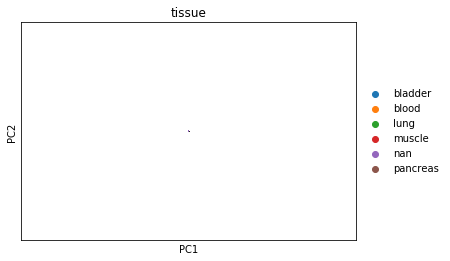

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:29)


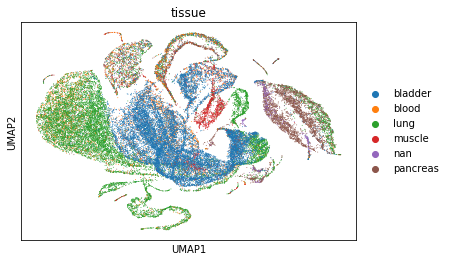

In [151]:
sc.tl.pca(adata_splicing)
sc.pl.pca(adata_splicing, color='tissue')
sc.pp.neighbors(adata_splicing, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata_splicing)
sc.pl.umap(adata_splicing,color='tissue')

In [157]:
adata_splicing = adata_splicing[adata_splicing.obs.index.isin(adata_splicing.obs.dropna().index)]

In [158]:
adata_splicing.obs_names_make_unique()

In [160]:
adata_splicing.write('../../data-objs/pilot1/TSP1_splicing_10X/TSP1_10X_splicing.h5ad')